In [1]:
%load_ext autoreload
%autoreload 2

In [107]:
import os
import math
import tqdm
import torch

import numpy as np

from video_dataset.video import VideoFromVideoFile
from bouldering_video_segmentation.utils import LabelEncoderFactory

from tas_helpers.visualization import SegmentationVisualizer

from bouldering_video_segmentation.models import VideoSegmentMlp
from bouldering_video_segmentation.extractors import X3DFeatureExtractor, X3DModelType

<div class="alert alert-warning">

**Information:** The constants below (`VIDEO_PATH` and `VIDEO_SEGMENT_MLP_MODEL_WEIGHTS_PATH`) are to be defined. You can find an example video and the models weights in the github repository.

</div>

In [13]:
VIDEO_PATH = "/Users/nadir/Documents/research-project-example-videos/climb_1-climber_MoubeAdrian-bloc_1-angle_face.mp4"
SEGMENT_SIZE = 32
NUMBER_OF_CLASSES = 5
VIDEO_SEGMENT_MLP_MODEL_WEIGHTS_PATH = "models-weights/mlp.x3d-xs.pt"

In [14]:
video_dir_path = "/".join(VIDEO_PATH.split("/")[:-1])
video_name, video_extension = VIDEO_PATH.split("/")[-1].split(".")

In [15]:
print(f"[video-path]: {os.path.join(video_dir_path, f"{video_name}.{video_extension}")}")

[video-path]: /Users/nadir/Documents/research-project-example-videos/climb_1-climber_MoubeAdrian-bloc_1-angle_face.mp4


In [72]:
extractor = X3DFeatureExtractor(X3DModelType.XS)

model = VideoSegmentMlp(
    input_size=extractor.get_features_shape(),
    # NOTE: the model has been trained on 5 classes, thus the output size is 5 and can't be changed when used with the provided weights
    output_size=NUMBER_OF_CLASSES
)

incompatible_keys = model.load_state_dict(torch.load(VIDEO_SEGMENT_MLP_MODEL_WEIGHTS_PATH))

model = model.eval()

print(f"[incompatible-keys]: {incompatible_keys}")

video = VideoFromVideoFile(
    videos_dir_path=video_dir_path,
    id=video_name,
    video_extension=video_extension
)

[incompatible-keys]: <All keys matched successfully>


Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [73]:
print(f"[#segments]: {math.ceil(len(video) / SEGMENT_SIZE)}")

# NOTE: (Time, Height, Width, Channels)
print(f"[video[0].shape]: {video[0].shape}")

# NOTE: (Time, Height, Width, Channels)
print(f"[video[0:10].shape]: {video[0:10].shape}")

[#segments]: 221
[video[0].shape]: (1920, 1080, 3)
[video[0:10].shape]: (10, 1920, 1080, 3)


In [76]:
features = []
predictions = []

for i in tqdm.tqdm(iterable=range(0, len(video), SEGMENT_SIZE), desc="[processing-video-segments]:"):
    segment = video[i:i+SEGMENT_SIZE]
    # NOTE: required to be transposed to (Channel, Time, Height, Width)
    segment = segment.transpose(3, 0, 1, 2)
    feature = extractor.transform_and_extract(segment)
    feature = feature.unsqueeze(0)
    prediction = model(feature)
    
    features.append(feature)
    predictions.append(prediction)

[processing-video-segments]:: 100%|██████████| 221/221 [02:36<00:00,  1.41it/s]


In [103]:
_, labels = torch.max(torch.stack(predictions), dim=2)

In [104]:
frames_predictions = np.repeat(labels.numpy(), SEGMENT_SIZE)

<Axes: >

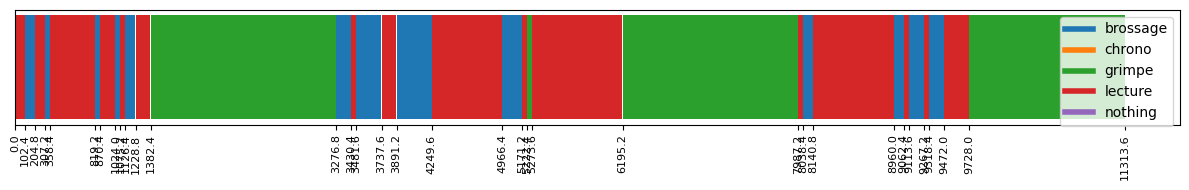

In [115]:
label_encoder = LabelEncoderFactory.get()

visualizer = SegmentationVisualizer(
    labels_values=label_encoder.transform(label_encoder.classes_),
    labels_names=label_encoder.classes_
)

visualizer.plot_segmentation(
    frames_labels=frames_predictions,
    fps=25
)